# Coupling rainfall-runoff-soil moisture in Landlab

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

This notebook illustrate the coupling of `SpatialPrecipitationDistribution` and `OverlandFlow` is based of the tutorial **Coupled rainfall runoff model with OverlandFlow**, on which we couple `infiltrate_soil_green_ampt`.

### First, we import what we need

In [14]:
import numpy as np
from landlab.io import read_esri_ascii
from landlab import imshow_grid_at_node
from landlab.components import OverlandFlow
import matplotlib.pyplot as plt
from landlab.components import SoilInfiltrationGreenAmpt
from landlab.components.uniform_precip import PrecipitationDistribution
import random

### Then set up for the model run

Q2 - How does different rainfall events regulates depth of the water front entering the soil during a storm ?

--> change the parameters of the rainfall generator to observe how the duration of the storm, and the intensity impacts 
- the `soil_water_infiltration__depth`, which is the front of water entering the soil.
- the `surface_water__depth`, which is the water height flowing on the surface.

# Conceptual Model
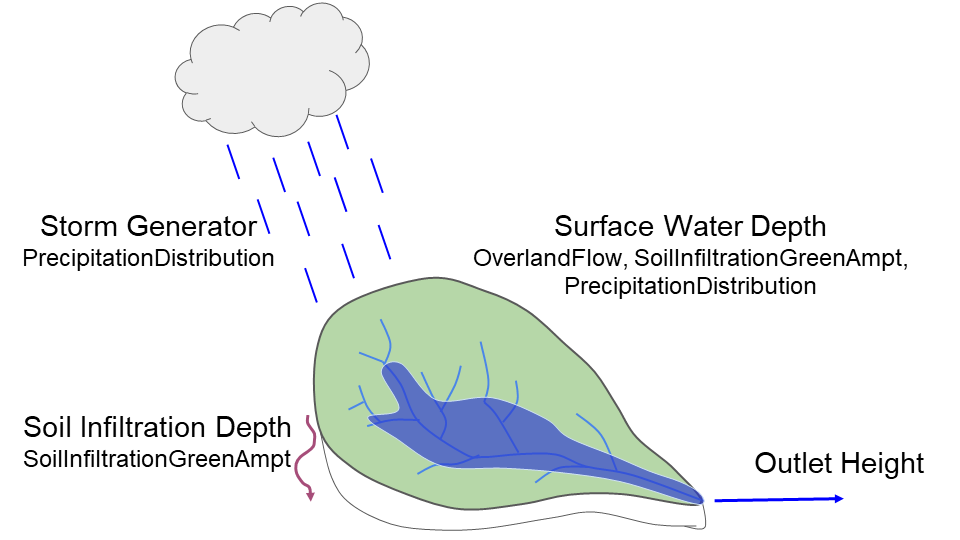

In [18]:
#Create the grid using topographique value from an asci file.
fname = 'hugo_site.asc'
mg, z = read_esri_ascii(fname, name='topographic__elevation')
mg.status_at_node[mg.nodes_at_right_edge] = mg.BC_NODE_IS_FIXED_VALUE
mg.status_at_node[np.isclose(z, -9999.)] = mg.BC_NODE_IS_CLOSED

#Define the parameter for rainfall generator
mean_duration = 2 #hours
mean_inter_duration = 10 #(h)
mean_storm_depth = 0.5 #(m) mean water heig
total_time  = 10 #(h)
delta_t = 1; # 
np.random.seed(np.arange(10)) #make sure that we are making the same random sequence everytime

#Generate the storm
precip = PrecipitationDistribution(mg, mean_storm_duration=mean_duration, mean_interstorm_duration=mean_inter_duration, mean_storm_depth=mean_storm_depth, total_t=total_time,delta_t=delta_t)
n = 5 #seed number, a certain seed gives a specific storm for the chosen parameters ##random.randint(1,101) #random number for stochastic results.
precip.seed_generator(seedval=n) #

Define parameters for the infiltration component

Q1 - How does the soil hydraulic conductivity impact stream discharge?

--> change the hydraulic conductivity between 1e-5 and 1e-7, and look at how it impacts the stream discharge.

In [9]:
hydraulic_conductivity = mg.ones('node')*1e-6 #<<-- change this parameter to create more soil infiltration
h = mg.add_ones("surface_water__depth", at="node")
mg.at_node['surface_water__depth'].fill(1.e-12)  # a veneer of water stabilises the model
h *= 0.01
d = mg.add_ones("soil_water_infiltration__depth", at="node", dtype=float)
d *= 0.2

In [10]:
SI = SoilInfiltrationGreenAmpt(mg,hydraulic_conductivity=hydraulic_conductivity,soil_type='clay')
of = OverlandFlow(mg, steep_slopes=True)

### Loop through time

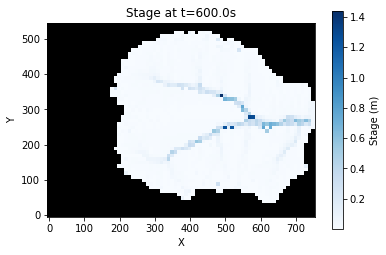

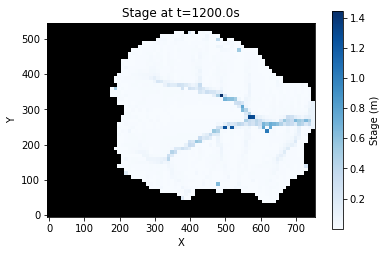

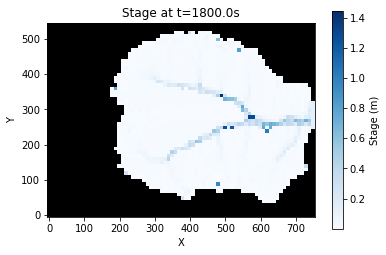

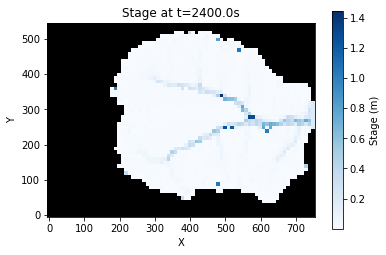

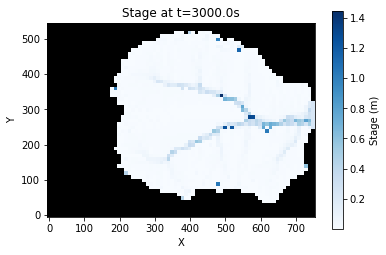

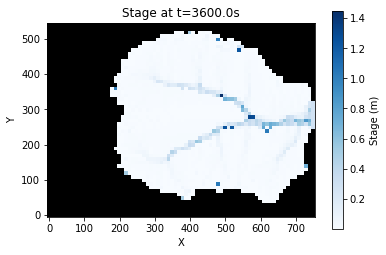

In [11]:
for (storm_t, interstorm_dt) in precip.yield_storms():
    
    node_of_max_q = 2126
    total_mins_to_plot = 60  # in minutes.
    plot_interval_mins = 10  
    min_tstep_val = 1.  # necessary to get the model going cleanly
    outlet_depth = [] 
    outlet_times = []
    storm_elapsed_time = 0
    total_elapsed_time = 0
    last_storm_loop_tracker = 0
    
    while total_elapsed_time < total_mins_to_plot * 60:
        dt = of.calc_time_step()
        remaining_total_time = total_mins_to_plot * 60 - total_elapsed_time
        if storm_elapsed_time < storm_t * 3600:
            remaining_storm_time = storm_t * 3600 - storm_elapsed_time
            dt = min((dt, remaining_total_time, remaining_storm_time, min_tstep_val))
        else:
            dt = min((dt, remaining_total_time, min_tstep_val))
        of.run_one_step(dt=dt)
        SI.run_one_step(dt=dt) 
        total_elapsed_time += dt
        storm_elapsed_time += dt
        storm_loop_tracker = total_elapsed_time % (plot_interval_mins * 60)
        
        if storm_loop_tracker < last_storm_loop_tracker:
            plt.figure()
            imshow_grid_at_node(
                mg,
                'surface_water__depth',
                var_name='Stage (m)',cmap ='Blues')
            plt.title('Stage at t=' + str(total_elapsed_time//1) + 's')
            plt.show()
        last_storm_loop_tracker = storm_loop_tracker
        outlet_depth.append(mg.at_node['surface_water__depth'][node_of_max_q])
        outlet_times.append(total_elapsed_time)
        if storm_elapsed_time < storm_t * 3600:
            mg.at_node['surface_water__depth'] += mg.at_grid['rainfall__flux'] * dt / 3600

Text(0, 0.5, 'Flood stage (m)')

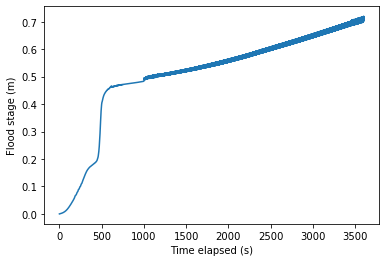

In [12]:
## Plotting Hydrograph in the outlet
plt.figure()
plt.plot(outlet_times, outlet_depth, '-')
plt.xlabel('Time elapsed (s)')
plt.ylabel('Flood stage (m)')